In [1]:
import pandas as pd
import featuretools as ft
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, cross_val_score
import numpy as np
from tpot import TPOTClassifier
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import balanced_accuracy_score
import joblib  # 用于保存交互项模式和模型
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, classification_report

from lightgbm import LGBMClassifier
import lightgbm as lgb

In [2]:
X_y_group_train = pd.read_csv('./mid_data/X_y_group_train_updated_v13.1_sem.csv')

def remove_columns_with_keywords(df, keywords):
    columns_to_drop = [col for col in df.columns if any(keyword in col for keyword in keywords)]
    return df.drop(columns=columns_to_drop)

print("Adding numeric labels y")
le = LabelEncoder()
X_y_group_train["y"] = le.fit_transform(X_y_group_train["label"])
# reordering columns:
X_y_group_train = X_y_group_train[["dataset", "variable"] + X_y_group_train.columns.drop(["dataset", "variable", "label", "y"]).tolist() + ["label", "y"]]


blacklist = ["ttest(v,X)", "pvalue(ttest(v,X))<=0.05", "ttest(v,Y)", "pvalue(ttest(v,Y))<=0.05", "ttest(X,Y)", "pvalue(ttest(X,Y))<=0.05"]
columns_to_drop = [col for col in blacklist if col in X_y_group_train.columns]
X_y_group_train = X_y_group_train.drop(columns=columns_to_drop)


keywords_to_remove = []  
X_y_group_train = remove_columns_with_keywords(X_y_group_train, keywords_to_remove)

numeric_columns = X_y_group_train.select_dtypes(include=[np.number]).columns
X_y_group_train[numeric_columns] = X_y_group_train[numeric_columns].fillna(X_y_group_train[numeric_columns].mean())

display(X_y_group_train)

print("Extracting X_train, y_train, and group")
X_train = X_y_group_train.drop(["variable", "dataset", "label", "y"], axis="columns")

y_train = X_y_group_train["y"]
group_train = X_y_group_train["dataset"]

Adding numeric labels y


,dataset,variable,dimension,"corr(v,X)","corr(v,Y)","max(corr(v, others))","min(corr(v, others))","mean(corr(v, others))","std(corr(v, others))","corr(X,Y)",...,TLI_Mediator,RMSEA_Cause of X,RMSEA_Cause of Y,RMSEA_Collider,RMSEA_Confounder,RMSEA_Consequence of X,RMSEA_Consequence of Y,RMSEA_Mediator,label,y
0,0,0,8,0.169735,-0.113595,0.791467,0.027355,0.282376,0.298969,-0.771058,...,-1.870213,0.000000,0.0,inf,inf,0.000000,0.126570,0.943596,Consequence of Y,5
1,0,2,8,-0.072334,0.139419,0.230139,0.003233,0.090511,0.082201,-0.771058,...,-1.925606,0.128511,0.0,inf,inf,0.128511,0.046016,0.948937,Independent,6
2,0,3,8,0.123115,-0.238769,0.781051,0.012225,0.257037,0.288165,-0.771058,...,-1.776985,0.228595,0.0,inf,inf,0.228595,0.093729,0.947160,Cause of Y,1
3,0,4,8,-0.001935,0.013921,0.147408,0.001935,0.052451,0.053457,-0.771058,...,-2.006007,0.000000,0.0,inf,inf,0.000000,0.000000,0.950159,Cause of Y,1
4,0,5,8,0.284323,-0.466570,0.791467,0.064815,0.426306,0.250048,-0.771058,...,-1.154666,0.422475,0.0,inf,inf,0.422475,0.130832,0.914523,Mediator,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142905,46997,6,7,0.014740,0.697089,0.748635,0.013858,0.376630,0.352655,-0.089641,...,0.918142,0.822573,0.0,inf,inf,0.822573,0.103806,0.136507,Cause of Y,1
142906,46997,7,7,-0.007397,-0.116481,0.998843,0.007397,0.180741,0.333308,-0.089641,...,-0.155460,0.113774,0.0,inf,inf,0.113774,0.000000,0.085709,Cause of Y,1
142907,46997,8,7,-0.011658,0.908029,0.970364,0.011658,0.469777,0.441105,-0.089641,...,0.940344,1.330107,0.0,inf,inf,1.330107,0.165422,0.187894,Cause of Y,1
142908,46998,0,2,0.083546,-0.019665,0.083546,0.016856,0.040022,0.037719,0.036862,...,0.747848,0.000000,0.0,inf,inf,0.000000,0.078394,0.022254,Consequence of X,4


Extracting X_train, y_train, and group


In [3]:
import re

def clean_feature_names(X):
    # 定义特殊字符到可接受字符的映射
    char_map = {
        '(': 'a', ')': 'b', '[': 'c', ']': 'd', '{': 'e', '}': 'f',
        '<': 'g', '>': 'h', '=': 'i', '+': 'j', '-': 'k', '*': 'l',
        '/': 'm', '\\': 'n', '|': 'o', '&': 'p', '^': 'q', '%': 'r',
        '$': 's', '#': 't', '@': 'u', '!': 'v', '~': 'w', '`': 'x',
        ':': 'y', ';': 'z', ',': 'A', '.': 'B', '?': 'C', "'": 'D',
        '"': 'E', ' ': '_'  # 空格替换为下划线
    }

    def clean_name(name):
        # 使用映射替换特殊字符
        for char, replacement in char_map.items():
            name = name.replace(char, replacement)
        
        # 确保名称不以数字开头
        if name[0].isdigit():
            name = 'f_' + name
        return name

    X.columns = [clean_name(col) for col in X.columns]
    return X

# 清理特征名称
X_train = clean_feature_names(X_train)

Best LGBM Pharamter now:
```python
model = LGBMClassifier(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=29,
    min_child_samples=20,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced',
    device='gpu',
    gpu_platform_id=1,
    gpu_device_id=0,
)
```

v12.1分数:0.6559
objective='multiclassova',
0.6567



In [4]:
# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [10]:

model = LGBMClassifier(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=29,
    min_child_samples=20,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=43,
    n_jobs=-1,
    class_weight='balanced',
    device='cpu',
    gpu_platform_id=1,
    gpu_device_id=0,
)
display(model)

# 定义回调函数
callbacks = [lgb.log_evaluation(period=1), lgb.early_stopping(stopping_rounds=10)]

# 训练模型
model.fit(X_train, y_train, callbacks=callbacks, eval_set=[(X_test, y_test)])

# 预测
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# 计算平衡准确率
train_score = balanced_accuracy_score(y_train, y_train_pred)
test_score = balanced_accuracy_score(y_test, y_test_pred)

print(f"Train balanced accuracy: {train_score:.6f}")
print(f"Test balanced accuracy: {test_score:.6f}")

# 输出详细的分类报告
print("\nClassification Report for Test Set:")
print(classification_report(y_test, y_test_pred))

LGBMClassifier(class_weight='balanced', colsample_bytree=0.7, device='cpu',
               gpu_device_id=0, gpu_platform_id=1, learning_rate=0.05,
               max_depth=7, n_estimators=2000, n_jobs=-1, num_leaves=29,
               random_state=43, reg_alpha=0.1, reg_lambda=0.1, subsample=0.7)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44953
[LightGBM] [Info] Number of data points in the train set: 114328, number of used features: 198
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[1]	valid_0's multi_logloss: 1.9493
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 1.84316
[3]	valid_0's multi_logloss: 1.75554
[4]	valid_0's multi_logloss: 1.68087
[5]	valid_0's multi_logloss: 1.61666
[6]	valid_0's multi_logloss: 1.

0.670



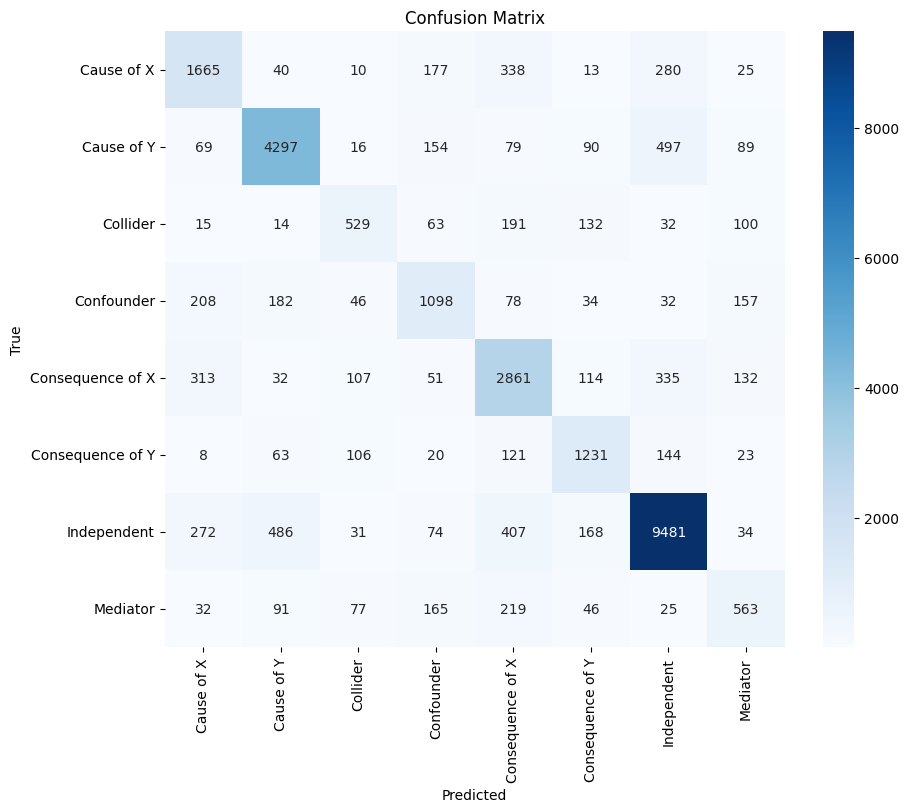

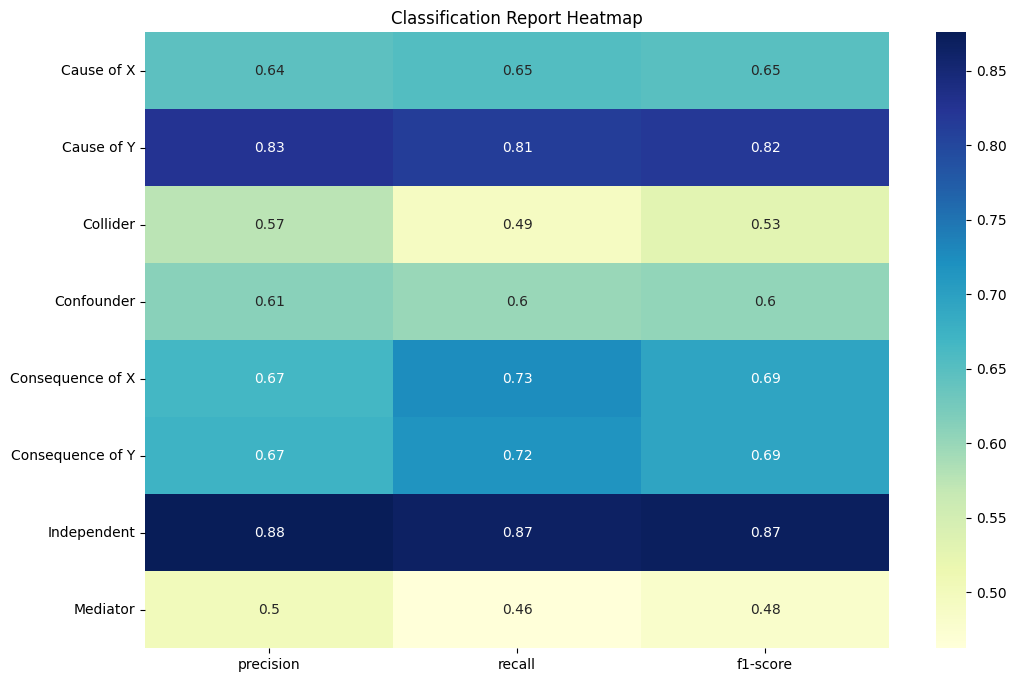

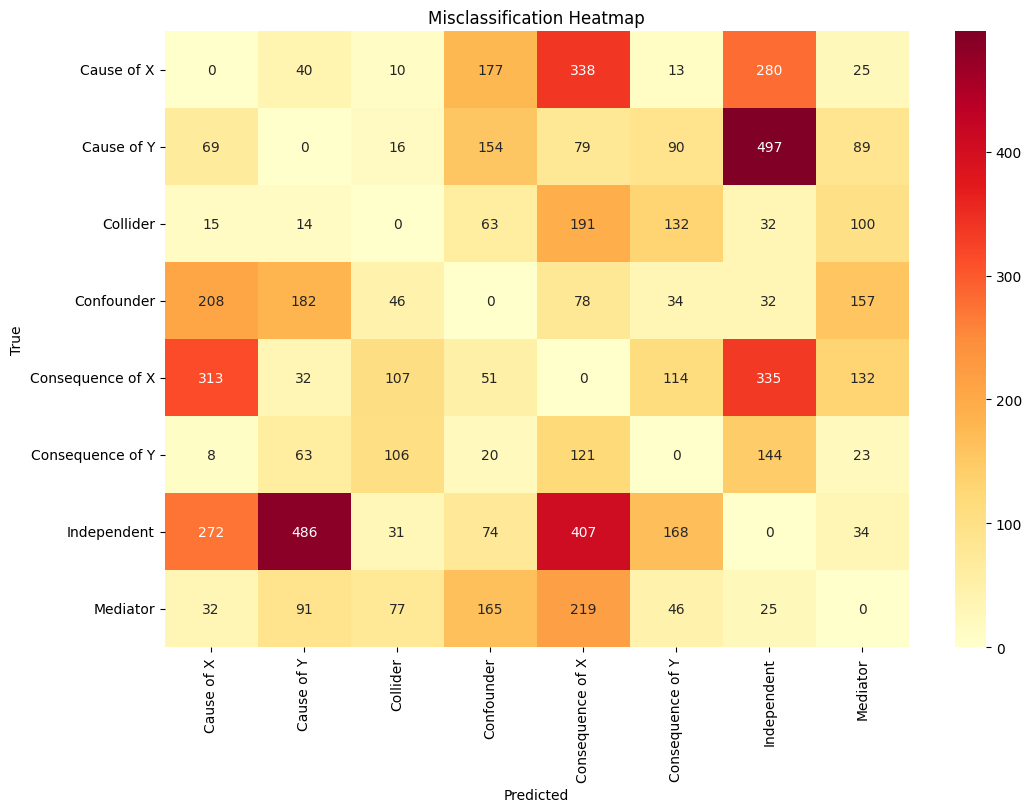

Most common misclassifications:
True              Predicted       
Cause of Y        Independent         497
Independent       Cause of Y          486
                  Consequence of X    407
Cause of X        Consequence of X    338
Consequence of X  Independent         335
                  Cause of X          313
Cause of X        Independent         280
Independent       Cause of X          272
Mediator          Consequence of X    219
Confounder        Cause of X          208
dtype: int64


In [6]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 假设我们已经有了预测结果 y_pred 和真实标签 y_true
# 如果没有,请先运行模型得到预测结果

# 1. 计算混淆矩阵

y_true = y_test
y_pred = y_test_pred

cm = confusion_matrix(y_true, y_pred)

# 2. 创建混淆矩阵热力图
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 3. 计算每个类别的精确度、召回率和F1分数
report = classification_report(y_true, y_pred, target_names=le.classes_, output_dict=True)

# 4. 创建分类报告可视化
df_report = pd.DataFrame(report).transpose()
plt.figure(figsize=(12, 8))
sns.heatmap(df_report.iloc[:-3, :-1].astype(float), annot=True, cmap='YlGnBu')
plt.title('Classification Report Heatmap')
plt.show()

# 5. 分析错误分类情况
misclassified = y_true != y_pred
error_df = pd.DataFrame({
    'True': le.inverse_transform(y_true[misclassified]),
    'Predicted': le.inverse_transform(y_pred[misclassified])
})
error_counts = error_df.groupby(['True', 'Predicted']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(error_counts, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Misclassification Heatmap')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 打印最常见的错误分类情况
print("Most common misclassifications:")
print(error_df.groupby(['True', 'Predicted']).size().sort_values(ascending=False).head(10))


Case Study 1:
Dataset: 0, Variable: 5, Dimension: 8
True Label: Mediator, Predicted Label: Consequence of Y


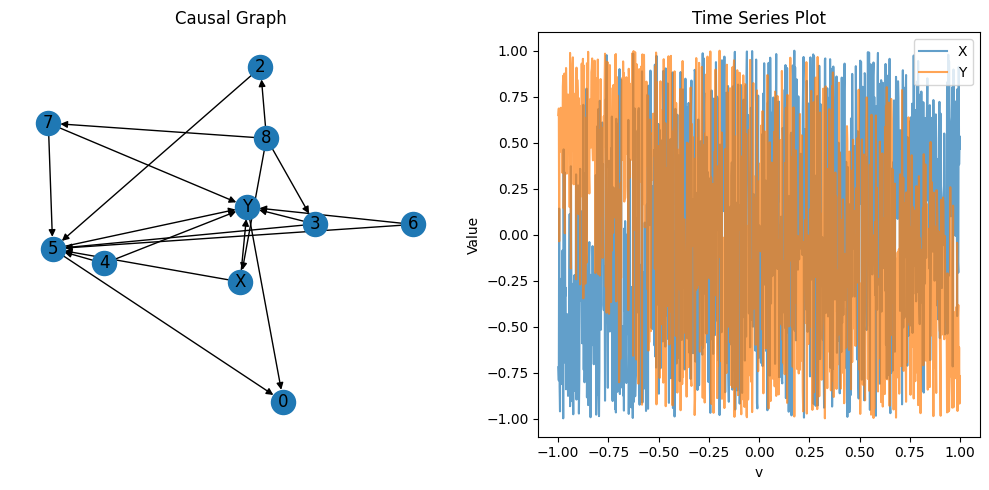

In [7]:
import networkx as nx

y_data_origin = pd.read_pickle('./data/y_train.pickle')
x_data_origin = pd.read_pickle('./data/x_train.pickle')

# 案例研究：错误分类样本分析
def case_study_misclassifications(X, y_true, y_pred, le, original_data, n_samples=5):
    misclassified = y_true != y_pred
    error_df = pd.DataFrame({
        'True': le.inverse_transform(y_true[misclassified]),
        'Predicted': le.inverse_transform(y_pred[misclassified])
    })
    
    # 添加原始数据的其他特征
    error_df = pd.concat([error_df, X[misclassified].reset_index(drop=True)], axis=1)
    error_df['dataset'] = original_data.loc[X[misclassified].index, 'dataset'].values
    error_df['variable'] = original_data.loc[X[misclassified].index, 'variable'].values
    error_df['dimension'] = original_data.loc[X[misclassified].index, 'dimension'].values
    
    # 按数据集和维度分组，并随机选择样本
    grouped = error_df.groupby(['dataset', 'dimension'])
    selected_samples = []
    
    for _, group in grouped:
        if len(selected_samples) < n_samples:
            selected_samples.append(group.sample(n=1))
    
    selected_df = pd.concat(selected_samples).reset_index(drop=True)
    
    # 对每个选中的样本进行分析
    for idx, row in selected_df.iterrows():
        print(f"\nCase Study {idx + 1}:")
        print(f"Dataset: {row['dataset']}, Variable: {row['variable']}, Dimension: {row['dimension']}")
        print(f"True Label: {row['True']}, Predicted Label: {row['Predicted']}")
        
        # 可视化该数据集的因果图
        dataset = row['dataset']
        dataset = str(dataset).zfill(5)
        
        full_graph_labels = y_data_origin[dataset]
        
        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        visualize_causal_graph(full_graph_labels)
        plt.title("Causal Graph")
        
        # 绘制折线图
        plt.subplot(122)
        plot_time_series(x_data_origin[dataset], row['variable'])
        plt.title("Time Series Plot")
        
        plt.tight_layout()
        plt.show()
        
        # 显示重要特征
        # important_features = X.columns[np.argsort(model.feature_importances_)[-10:][::-1]]
        # feature_values = row[important_features]
        # print("\nTop 10 Important Features:")
        # print(feature_values)
        break


def visualize_causal_graph(labels):
    g = nx.DiGraph(labels)
    nx.draw(g, with_labels=True)
    
def plot_time_series(data, v):
    v_col = f"{v}"
    x_col = f"X"
    y_col = f"Y"
    
    data = data.sort_values(by=f'{v}', ascending=False)
    plt.plot(data[v_col], data[x_col], label='X', alpha=0.7)
    plt.plot(data[v_col], data[y_col], label='Y', alpha=0.7)
    plt.xlabel('v')
    plt.ylabel('Value')
    plt.legend()


# 运行案例研究
case_study_misclassifications(X_test, y_test, y_test_pred, le, X_y_group_train, n_samples=5)



                   feature  importance
85         Ywv_coefficient        3876
149    Xwv_piecewise_coef4        3666
145    vwX_piecewise_coef4        3574
108    Ywv_DML_AMTE_pvalue        3531
45   vwX_ridge_coefficient        3470
..                     ...         ...
122      vwX_sliding_coef4         575
129      Xwv_sliding_coef1         571
49        ExactSearchavAYb         571
119      vwX_sliding_coef1         571
133      Xwv_sliding_coef5         565

[150 rows x 2 columns]


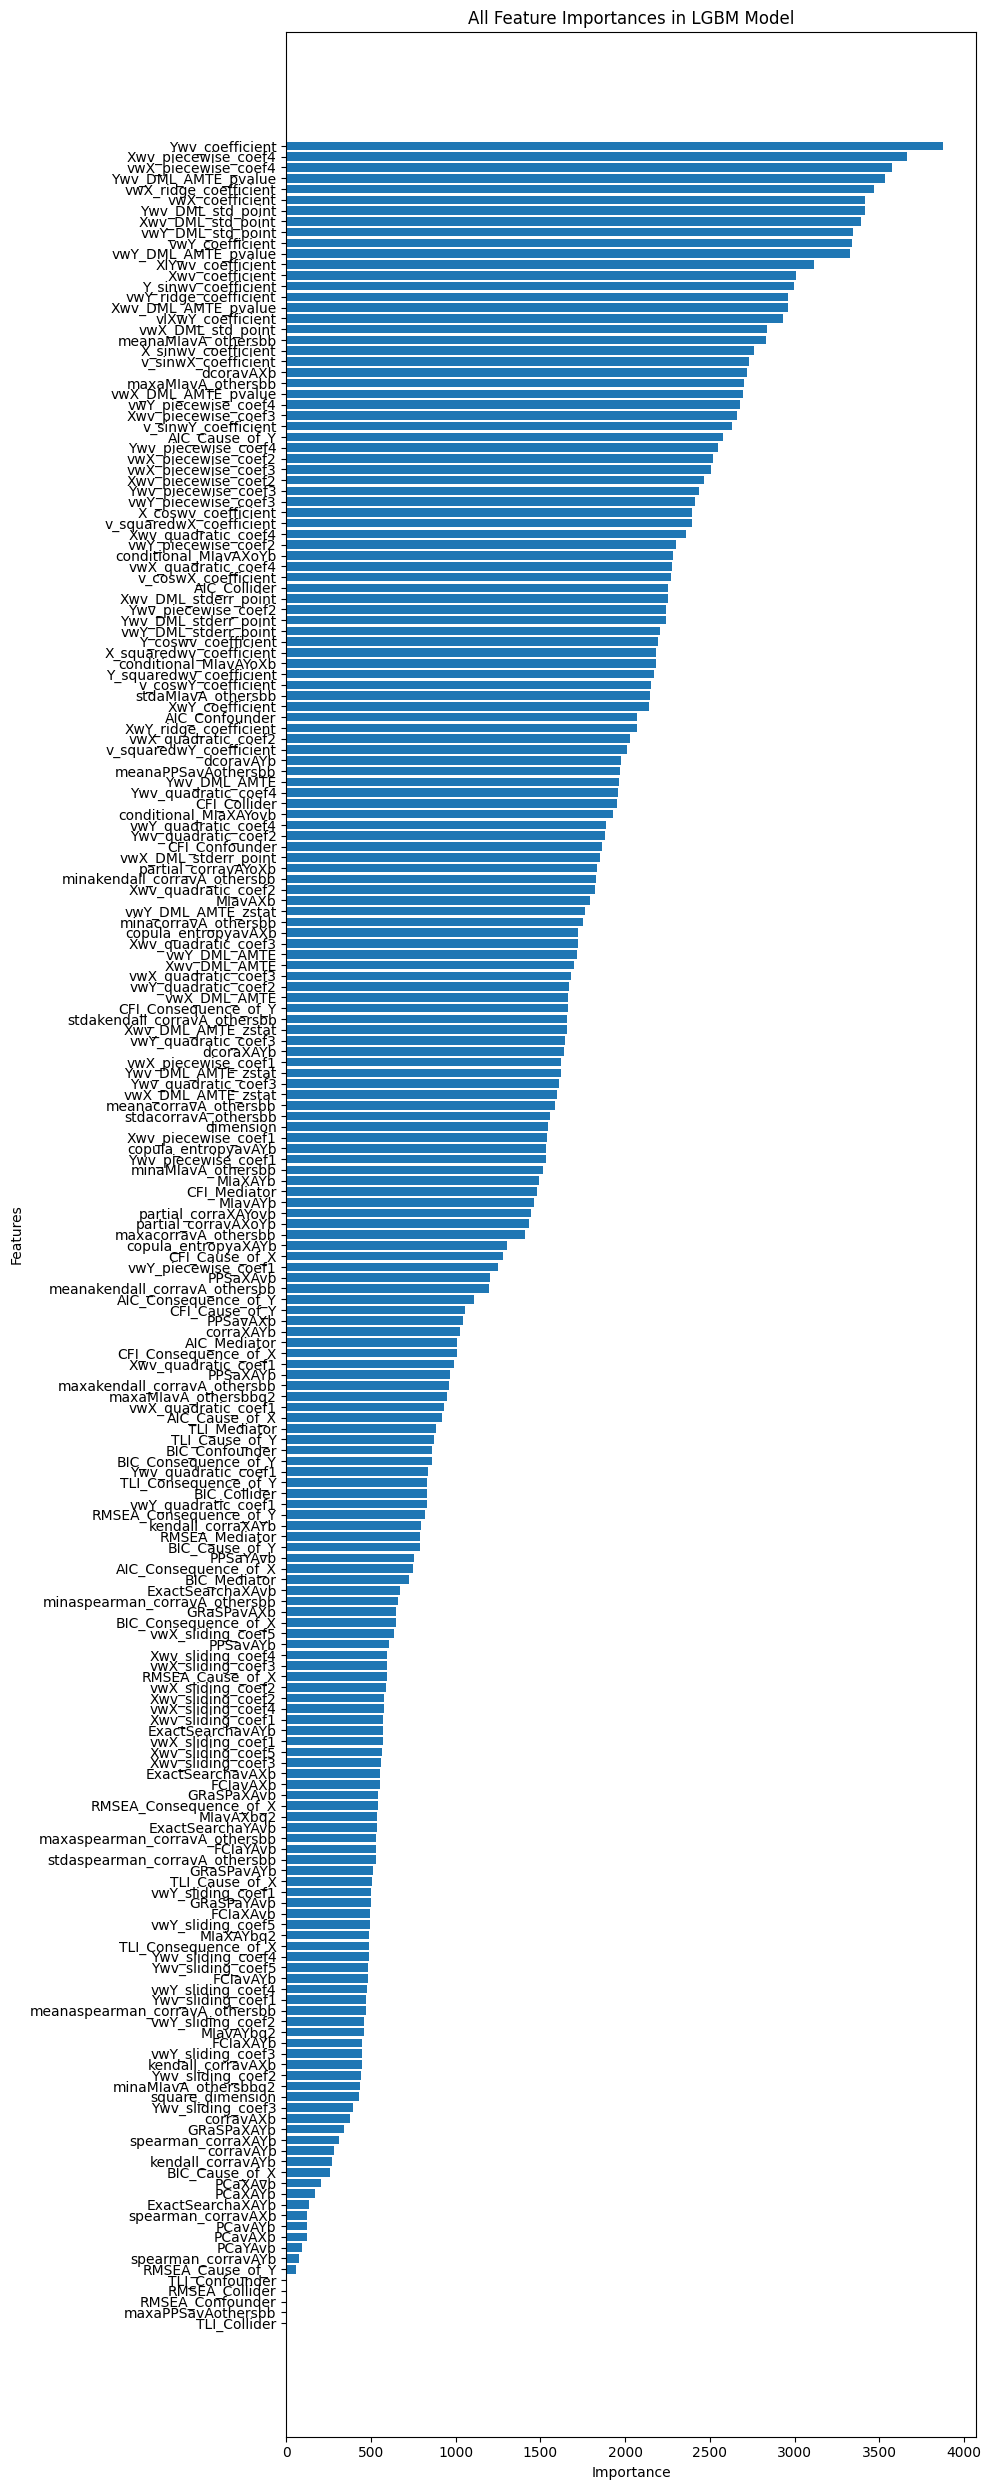

In [9]:
feature_importance = model.feature_importances_
feature_names = X_train.columns

# Create a dataframe of feature importances
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

# Display top 20 features
print(feature_importance_df.head(150))

# Optionally, you can plot the feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 25))  # 调整图形大小，使其更高
plt.barh(feature_importance_df['feature'][:][::-1], feature_importance_df['importance'][:][::-1])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('All Feature Importances in LGBM Model')
plt.tight_layout()
plt.show()

In [26]:
print(feature_importance_df.head(150))

                 feature  importance
149  Xwv_piecewise_coef4        4614
145  vwX_piecewise_coef4        4566
85       Ywv_coefficient        4480
108  Ywv_DML_AMTE_pvalue        4250
98   vwY_DML_AMTE_pvalue        4229
..                   ...         ...
15    spearman_corravAXb         198
51      ExactSearchaXAYb         187
54               PCavAYb         151
55               PCaYAvb         141
52               PCavAXb         129

[150 rows x 2 columns]


In [49]:
feature_importance_df

,feature,importance
85,Ywv_coefficient,4335
145,vwX_piecewise_coef4,4190
149,Xwv_piecewise_coef4,4077
45,vwX_ridge_coefficient,4014
108,Ywv_DML_AMTE_pvalue,3970
...,...,...
15,spearman_corravAXb,149
52,PCavAXb,131
55,PCaYAvb,113
16,spearman_corravAYb,98
